# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [121]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA    
import operator


# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [122]:
# Load in the general demographics data.
azdias = pd.read_csv('./Udacity_AZDIAS_Subset.csv', delimiter=';')


In [123]:
# Load in the feature summary file.
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', delimiter=';')

In [124]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.shape

(891221, 85)

In [125]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [126]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [127]:
feat_info.shape

(85, 4)

In [128]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [129]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,CAMEO_DEUG_2015,person,ordinal,[-1]
freq,1,43,49,26


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [130]:
# Identify missing or unknown data values and convert them to NaNs.
# Convert missing_or_unknown to list 
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))

# Identify missing or unknown data values and convert them to NaNs.
for attrib, missing_values in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
    if missing_values[0] != '':
        for value in missing_values:
            if value.isnumeric() or value.lstrip('-').isnumeric():
                value = int(value)
            azdias.loc[azdias[attrib] == value, attrib] = np.nan



In [131]:
azdias

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2.0,5.0,1.0,5.0,1.0,5.0,4.0,3.0,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1.0,3.0,3.0,3.0,4.0,1.0,3.0,2.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1.0,3.0,4.0,4.0,2.0,4.0,2.0,2.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2.0,4.0,2.0,4.0,2.0,3.0,5.0,4.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [132]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
miss_each_col = (azdias.isnull().mean())
print('The following table is a summary of the distribution of missing values per column','\n',miss_each_col.describe())
missing_data = azdias.isnull().sum()
#get the percentage
missing_data = missing_data[missing_data > 0]/(azdias.shape[0]) * 100
#sort the values
missing_data.sort_values(inplace=True)



The following table is a summary of the distribution of missing values per column 
 count    85.000000
mean      0.110541
std       0.164498
min       0.000000
25%       0.000000
50%       0.104517
75%       0.130736
max       0.997576
dtype: float64


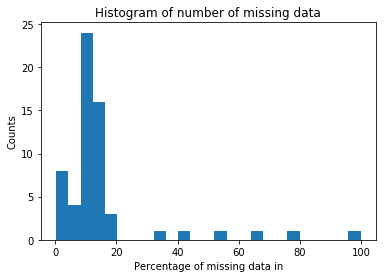

In [133]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(missing_data,25)
plt.xlabel('Percentage of missing data in')
plt.ylabel('Counts')
plt.title('Histogram of number of missing data')
plt.show()

In [134]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

missing_data.sort_values(ascending=False)

TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
REGIOTYP                 17.735668
KKK                      17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG1              14.959701
KBA05_ANTG3              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG4              14.959701
MOBI_REGIO               14.959701
KBA05_GBZ                14.959701
PLZ8_ANTG1               13.073637
PLZ8_ANTG2               13.073637
PLZ8_ANTG3               13.073637
PLZ8_GBZ                 13.073637
PLZ8_ANTG4               13.073637
PLZ8_BAUMAX              13.073637
PLZ8_HHZ                 13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV 

In [135]:
# find colnames that have high missing rate
missing_data[missing_data > 20].index.tolist()

['ALTER_HH',
 'GEBURTSJAHR',
 'KBA05_BAUMAX',
 'KK_KUNDENTYP',
 'AGER_TYP',
 'TITEL_KZ']

In [136]:
# Remove the outlier columns from the dataset. (You'll perform other data engineering tasks such as re-encoding and imputation later.)
azdias = azdias.drop(['AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX'], axis = 1)


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

The assessment of missing data for each column shows that 11 % of the data are missing on avarage, with a range from zero to almost everything missing in these columns. With further investigation, the percentage of missing values per column lies between 0 and 20 %. Therefore we drop the columns with missing data above 20 %. In our case 6 columns, since they are differing from the passive part of the distribution. 



#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [137]:
# How much data is missing in each row of the dataset?
missing_data_rows = azdias.isnull().sum(axis = 1)
missing_data_rows.describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

732775    62.025316
643174    62.025316
472919    60.759494
604334    59.493671
604314    59.493671
768879    59.493671
604319    59.493671
604322    59.493671
604323    59.493671
275622    59.493671
62901     59.493671
275620    59.493671
604332    59.493671
275617    59.493671
604305    59.493671
275611    59.493671
275610    59.493671
62912     59.493671
604335    59.493671
604338    59.493671
604346    59.493671
604350    59.493671
146293    59.493671
604356    59.493671
62887     59.493671
768892    59.493671
146291    59.493671
348454    59.493671
604091    59.493671
604092    59.493671
            ...    
38561      1.265823
768647     1.265823
607245     1.265823
709042     1.265823
507663     1.265823
607271     1.265823
561427     1.265823
235434     1.265823
235435     1.265823
235445     1.265823
607405     1.265823
62924      1.265823
144785     1.265823
91916      1.265823
820005     1.265823
607433     1.265823
709002     1.265823
38612      1.265823
144760     1.265823


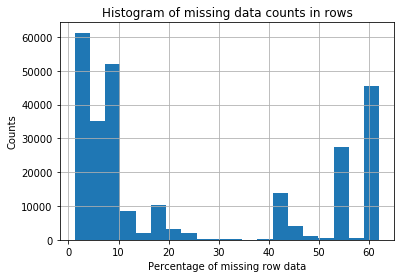

In [138]:
#Percentage of missing data per each row 
missing_data_rows = missing_data_rows[missing_data_rows > 0]/(len(azdias.columns)) * 100
print(missing_data_rows.sort_values(ascending=False))
missing_data_rows.sort_values(inplace=True)

plt.hist(missing_data_rows, bins=20)
plt.xlabel('Percentage of missing row data')
plt.ylabel('Counts')
plt.title('Histogram of missing data counts in rows')
plt.grid(True)
plt.show()

In [139]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
missing_data_rows_below_10 = azdias[azdias.isnull().sum(axis=1) < 10].reset_index(drop=True)
missing_data_rows_above_10 = azdias[azdias.isnull().sum(axis = 1) >= 10].reset_index(drop=True)



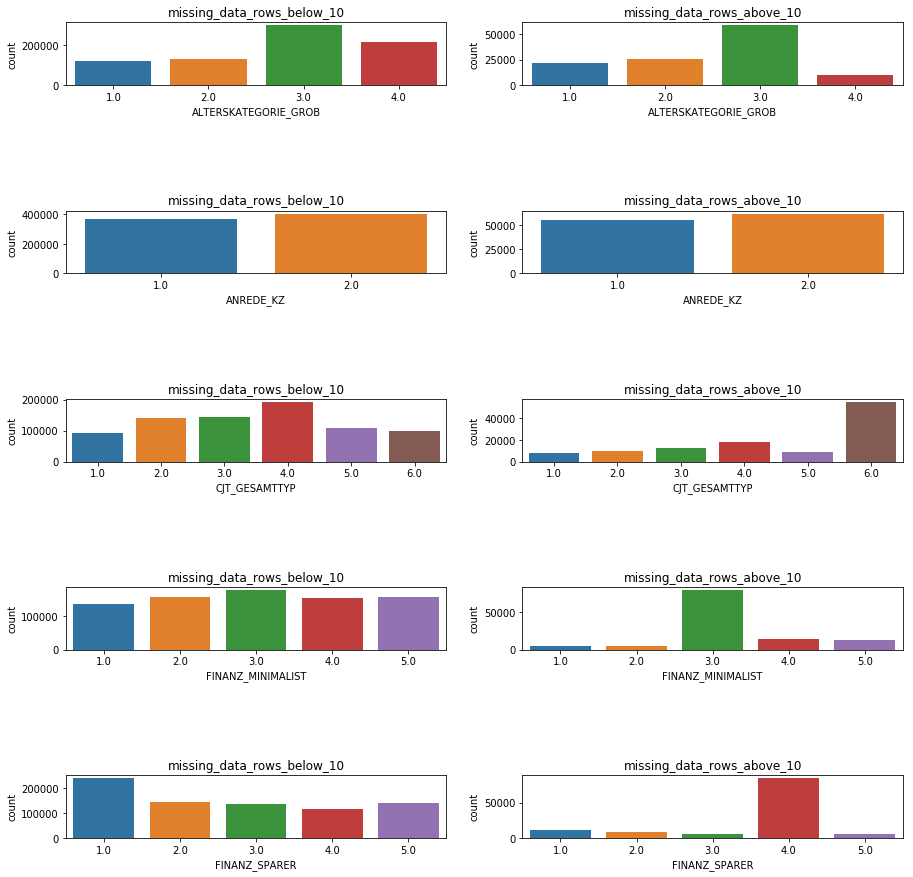

In [140]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def countplot(columns, num):
    fig, axs = plt.subplots(num, 2, figsize=(15, 15))
    fig.subplots_adjust(hspace =2 , wspace=.2)
    axs = axs.ravel()
    
    for i in range(num):
        
        sns.countplot(missing_data_rows_below_10[columns[i]], ax=axs[i*2])
        axs[i*2].set_title('missing_data_rows_below_10')
        sns.countplot(missing_data_rows_above_10[columns[i]], ax=axs[i*2+1])
        axs[i*2+1].set_title('missing_data_rows_above_10')
        
countplot(missing_data_rows_above_10.columns, 5)


In [141]:
#filling missing values in the few missing with the mean of the value
for col in missing_data_rows_below_10.columns:
    missing_data_rows_below_10[col] = missing_data_rows_below_10[col].interpolate(limit_direction='both')


#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

The assessment of missing data in each row showcased that 13 % of the data in each row where missing. With further investigation, the percentage of missing values per row lies between 0 and 10%. I therefore divided the data into two subgroups (missing_data_rows_below_10 and missing_data_rows_above_10), with a threshold of 10 missing values per row. It looks like distributions of columns differ between the groups of missing data below 10 and above 10. I have choosen to drop the rows with more than 10 missing values and interpolate the rest of the data by calculating the mean of the values. Dropping values can also have the side effect of decreasing the variance which can be important 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [142]:
# Load in the feature summary file 
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', delimiter=';')
feat_info.head(n=10)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [143]:
# Select the columns that are remaining in the azdias dataset 
feat_info = feat_info[feat_info.attribute.isin(azdias.columns)]

# How many features are there of each data type?
feat_info.groupby(['type'])['attribute'].count()

type
categorical    18
mixed           6
numeric         6
ordinal        49
Name: attribute, dtype: int64

In [144]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_variables = feat_info[feat_info['type'] == 'categorical']
categorical_variables

,attribute,information_level,type,missing_or_unknown
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]
21,NATIONALITAET_KZ,person,categorical,"[-1,0]"


In [145]:
# Split categorical variables into binary or multi buckets
categorical_binary = []
categorical_multi = []

for feature in list(categorical_variables['attribute']):
    if len(missing_data_rows_below_10[feature].value_counts()) > 2:
        categorical_multi.append(feature)
    else:
        categorical_binary.append(feature)
print(categorical_multi)

['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [146]:
for col in categorical_binary:
    print(missing_data_rows_below_10[col].value_counts())

2.0    403812
1.0    370931
Name: ANREDE_KZ, dtype: int64
0    604274
1    170469
Name: GREEN_AVANTGARDE, dtype: int64
0.0    768249
1.0      6494
Name: SOHO_KZ, dtype: int64
W    610258
O    164485
Name: OST_WEST_KZ, dtype: int64


In [147]:
missing_data_rows_below_10['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)
missing_data_rows_below_10['SOHO_KZ'].replace([0.0, 1.0], [1, 0], inplace=True)
missing_data_rows_below_10['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
missing_data_rows_below_10['ANREDE_KZ'].replace([2, 1], [1, 0], inplace=True)

In [148]:
#Dropping the multi level categorical variables
for column in categorical_multi:
    missing_data_rows_below_10=missing_data_rows_below_10.drop(column, axis=1)

In [149]:
# Do one-hot-encoding on all the binary categorical variables to be kept in the analysis.
missing_data_rows_below_10 = pd.get_dummies(missing_data_rows_below_10, columns=categorical_binary)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

I have standardized the binary categorical features (both numeric and non numeric) by re-encode the values as numbers with values of 0 or 1. I also kept the multi categorical variables and re-encoded them using the get_dummies function. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [150]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# Select mixed features names
mixed_features = feat_info[feat_info.type == 'mixed'].attribute
print(mixed_features)

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object


In [151]:
azdias[mixed_features].sample(15).T

,827361,588068,825653,111629,519168,632524,13057,331580,526435,268237,825017,108884,855569,220822,569549
LP_LEBENSPHASE_FEIN,NaN,10,7,12,19,32,7,7,1,10,2,8,14,20,NaN
LP_LEBENSPHASE_GROB,NaN,3,2,3,5,10,2,2,1,3,1,2,4,5,NaN
PRAEGENDE_JUGENDJAHRE,NaN,14,8,5,5,5,8,8,14,11,12,5,14,2,NaN
WOHNLAGE,NaN,3,7,7,7,3,3,3,3,7,4,NaN,3,1,NaN
CAMEO_INTL_2015,NaN,24,41,22,NaN,22,54,55,51,41,45,NaN,25,15,NaN
PLZ8_BAUMAX,NaN,1,1,1,1,1,2,2,5,5,5,NaN,2,1,NaN


In [152]:
missing_data_rows_below_10.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,...,ORTSGR_KLS9,RELAT_AB,ANREDE_KZ_0.0,ANREDE_KZ_1.0,GREEN_AVANTGARDE_0,GREEN_AVANTGARDE_1,SOHO_KZ_0.0,SOHO_KZ_1.0,OST_WEST_KZ_0,OST_WEST_KZ_1
0,1.0,1.0,5.0,2.0,5.0,4.0,5.0,3.0,21.0,6.0,...,5.0,4.0,0,1,1,0,1,0,0,1
1,3.0,1.0,4.0,1.0,2.0,3.0,5.0,3.0,3.0,1.0,...,5.0,2.0,0,1,0,1,0,1,0,1
2,4.0,4.0,2.0,5.0,2.0,1.0,2.0,2.0,17.5,5.5,...,3.0,3.0,0,1,1,0,0,1,0,1
3,3.0,4.0,3.0,4.0,1.0,3.0,2.0,3.0,32.0,10.0,...,6.0,5.0,1,0,1,0,0,1,0,1
4,1.0,3.0,1.0,5.0,2.0,2.0,5.0,3.0,8.0,2.0,...,3.0,3.0,0,1,1,0,0,1,0,1


In [153]:
# this information is based on the dictionary document
#Map generation 
gen_dict = {0: [1, 2], 
            1: [3, 4],
            2: [5, 6, 7],
            3: [8, 9],
            4: [10, 11, 12, 13], 
            5:[14, 15]}

def map_generation(x):
    try:
        for key, array in gen_dict.items():
            if x in array:
                return key
    except ValueError:
        return np.nan
    
# Map movement 
mainstream = [1, 3, 5, 8, 10, 12, 14]

def map_movevement(x):
    try:
        if x in mainstream:
            return 0
        else:
            return 1
    except ValueError:
        return np.nan

In [154]:
# Create generation column
missing_data_rows_below_10['PRAEGENDE_JUGENDJAHRE_decade'] = missing_data_rows_below_10['PRAEGENDE_JUGENDJAHRE'].apply(map_generation)

# Create movement column
missing_data_rows_below_10['PRAEGENDE_JUGENDJAHRE_movement'] = missing_data_rows_below_10['PRAEGENDE_JUGENDJAHRE'].apply(map_movevement)


In [155]:
# drop the original column
missing_data_rows_below_10.drop(['PRAEGENDE_JUGENDJAHRE'], axis = 1, inplace=True)

In [156]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# Wealth 
def classify_wealth(value):
    # In case value is NaN
    if pd.isnull(value):
        return np.nan
    else:
        # Return first digit
        return int(str(value)[0])

# Life stage
def classify_lifestage(value):
    # In case value is NaN
    if pd.isnull(value):
        return np.nan
    else:
        # Return second digit
        return int(str(value)[1])



In [157]:
# Create wealth column
missing_data_rows_below_10['CAMEO_INTL_2015_wealth'] = missing_data_rows_below_10['CAMEO_INTL_2015'].apply(classify_wealth)

# Create life stage column
missing_data_rows_below_10['CAMEO_INTL_2015_lifestage'] = missing_data_rows_below_10['CAMEO_INTL_2015'].apply(classify_lifestage)


In [158]:
# drop the original column
missing_data_rows_below_10.drop(['CAMEO_INTL_2015'], axis = 1, inplace=True)


In [159]:
# Remove unneeded and the rest of mixed columns (as per instruction above)
missing_data_rows_below_10 = missing_data_rows_below_10.drop(['PLZ8_BAUMAX',
                                                              'LP_LEBENSPHASE_FEIN',
                                                              'WOHNLAGE',
                                                              'LP_LEBENSPHASE_GROB'], axis=1)

In [160]:
missing_data_rows_below_10.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,GREEN_AVANTGARDE_0,GREEN_AVANTGARDE_1,SOHO_KZ_0.0,SOHO_KZ_1.0,OST_WEST_KZ_0,OST_WEST_KZ_1,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage
0,1.0,1.0,5.0,2.0,5.0,4.0,5.0,3.0,1.0,5.0,...,1,0,1,0,0,1,5.0,0,5.0,1.0
1,3.0,1.0,4.0,1.0,2.0,3.0,5.0,3.0,3.0,4.0,...,0,1,0,1,0,1,5.0,1,2.0,4.0
2,4.0,4.0,2.0,5.0,2.0,1.0,2.0,2.0,2.0,5.0,...,1,0,0,1,0,1,3.0,0,1.0,2.0
3,3.0,4.0,3.0,4.0,1.0,3.0,2.0,3.0,5.0,6.0,...,1,0,0,1,0,1,3.0,0,4.0,3.0
4,1.0,3.0,1.0,5.0,2.0,2.0,5.0,3.0,3.0,2.0,...,1,0,0,1,0,1,1.0,0,5.0,4.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

I have assessed the  mixed-type features and perforemd feature engineering on 'PRAEGENDE_JUGENDJAHRE' and "CAMEO_INTL_2015". 

"PRAEGENDE_JUGENDJAHRE_movement" has been decoded in "0" for MAINSTREAM and "1" for AVANTGARDE

"PRAEGENDE_JUGENDJAHRE_decade" has been decoded in 5 decades, "0" for 1940s, "1" for 1950s, "2" for 1960s, "3" for 1970s, "4" for 1980s and "5" for 1990s

"CAMEO_INTL_2015_wealth" has been decoded in  "1" for WEALTHY, "2" for PROSPEROUS, "3" for COMFORTABLE, "4" for LESS AFFLUENT and "5" for POORER

"CAMEO_INTL_2015_lifestage" : "1" for Pre-Family Couples & Singles, "2" for Young Couples With Children, "3" for Families With School Age Children, "4" for Older Families & Mature Couples and "5" for Elders In Retirement

I have chosen to drop the rest of the mixed type values (PLZ8_BAUMAX, LP_LEBENSPHASE_FEIN, WOHNLAGE, LP_LEBENSPHASE_GROB). PLZ8_BAUMAX is describing the most common building type within the PLZ8 region which is already covered by PLZ8_ANTG1 to PLZ8_ANTG4. LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB are describing the personal age level, salary level and household type and neighbourhoud quality which is also covered bby the other features. 


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [161]:
missing_data_rows_below_10.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
ALTERSKATEGORIE_GROB,1.0,3.0,4.0,3.0,1.0,2.0,1.0,3.0,3.0,3.0,3.000000,1.000000,4.0,1.000000,2.000000,3.0,2.0,1.0,3.0,1.0
FINANZ_MINIMALIST,1.0,1.0,4.0,4.0,3.0,1.0,3.0,4.0,2.0,2.0,5.000000,1.000000,4.0,4.000000,2.000000,5.0,3.0,1.0,5.0,3.0
FINANZ_SPARER,5.0,4.0,2.0,3.0,1.0,5.0,3.0,4.0,4.0,2.0,3.000000,4.000000,1.0,3.000000,4.000000,2.0,4.0,5.0,3.0,5.0
FINANZ_VORSORGER,2.0,1.0,5.0,4.0,5.0,1.0,4.0,2.0,2.0,5.0,4.000000,3.000000,5.0,1.000000,1.000000,3.0,1.0,3.0,3.0,3.0
FINANZ_ANLEGER,5.0,2.0,2.0,1.0,2.0,5.0,1.0,4.0,3.0,3.0,2.000000,5.000000,1.0,4.000000,5.000000,1.0,2.0,5.0,2.0,5.0
FINANZ_UNAUFFAELLIGER,4.0,3.0,1.0,3.0,2.0,4.0,3.0,2.0,5.0,1.0,4.000000,5.000000,1.0,5.000000,4.000000,3.0,5.0,5.0,2.0,4.0
FINANZ_HAUSBAUER,5.0,5.0,2.0,2.0,5.0,3.0,2.0,2.0,4.0,5.0,1.000000,2.000000,4.0,1.000000,1.000000,1.0,1.0,5.0,1.0,3.0
HEALTH_TYP,3.0,3.0,2.0,3.0,3.0,2.0,1.0,3.0,2.0,2.0,1.000000,3.000000,2.0,3.000000,2.000000,3.0,2.0,2.0,3.0,2.0
RETOURTYP_BK_S,1.0,3.0,2.0,5.0,3.0,4.0,5.0,4.0,4.0,5.0,5.000000,1.000000,5.0,1.000000,4.000000,5.0,3.0,1.0,5.0,1.0
SEMIO_SOZ,5.0,4.0,5.0,6.0,2.0,2.0,7.0,4.0,2.0,5.0,3.000000,2.000000,5.0,1.000000,1.000000,3.0,7.0,7.0,4.0,7.0


In [162]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
#check again for missing values
missing_data_rows_below_10.isnull().sum()

ALTERSKATEGORIE_GROB                  0
FINANZ_MINIMALIST                     0
FINANZ_SPARER                         0
FINANZ_VORSORGER                      0
FINANZ_ANLEGER                        0
FINANZ_UNAUFFAELLIGER                 0
FINANZ_HAUSBAUER                      0
HEALTH_TYP                            0
RETOURTYP_BK_S                        0
SEMIO_SOZ                             0
SEMIO_FAM                             0
SEMIO_REL                             0
SEMIO_MAT                             0
SEMIO_VERT                            0
SEMIO_LUST                            0
SEMIO_ERL                             0
SEMIO_KULT                            0
SEMIO_RAT                             0
SEMIO_KRIT                            0
SEMIO_DOM                             0
SEMIO_KAEM                            0
SEMIO_PFLICHT                         0
SEMIO_TRADV                           0
ANZ_PERSONEN                          0
ANZ_TITEL                             0


In [163]:
# Interpolate to remove the NaN values 
for col in missing_data_rows_below_10.columns:
        missing_data_rows_below_10[col] = missing_data_rows_below_10[col].interpolate(limit_direction='both')
    

In [164]:
# Remove those categorical variables has too many levels(more than 10)
azdias=azdias.drop(['GFK_URLAUBERTYP','LP_FAMILIE_FEIN','CAMEO_DEU_2015'],axis=1)


In [165]:
azdias_df = pd.read_csv('./Udacity_AZDIAS_Subset.csv', delimiter=';')

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [166]:
def clean_data(azdias):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """

    
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')
    feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))



    # Identify missing or unknown data values and convert them to NaNs.
    for attrib, missing_values in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
        if missing_values[0] != '':
            for value in missing_values:
                if value.isnumeric() or value.lstrip('-').isnumeric():
                    value = int(value)
                azdias.loc[azdias[attrib] == value, attrib] = np.nan

    #Remove selected columns
    azdias = azdias.drop(['AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX'], axis = 1)

    #Remove selected rows
    missing_data_rows_below_10 = azdias[azdias.isnull().sum(axis=1) < 10].reset_index(drop=True)
    
    #interpolate and impute the NaNs
    for col in missing_data_rows_below_10.columns:
        missing_data_rows_below_10[col] = missing_data_rows_below_10[col].interpolate(limit_direction='both')
    
    #Reencode the categorical and get dummies for the shopper type
    missing_data_rows_below_10['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)
    missing_data_rows_below_10['SOHO_KZ'].replace([0.0, 1.0], [1, 0], inplace=True)
    missing_data_rows_below_10['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
    missing_data_rows_below_10['ANREDE_KZ'].replace([2, 1], [1, 0], inplace=True)
    
    # select, re-encode, and engineer column values.
    #drop non categorical
    categorical_multi = ['CJT_GESAMTTYP','FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_FEIN',
                       'LP_FAMILIE_GROB','LP_STATUS_FEIN','LP_STATUS_GROB','NATIONALITAET_KZ',
                       'SHOPPER_TYP','VERS_TYP','ZABEOTYP','GEBAEUDETYP','CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

    
    
    for col in categorical_multi:
        missing_data_rows_below_10.drop(col, axis=1, inplace=True)
    
    # Do one-hot-encoding and remove reference columns
    missing_data_rows_below_10 = pd.get_dummies(missing_data_rows_below_10, columns=categorical_binary)

    # Complete the mapping process of mixed features
    # Create generation column and movement column
    missing_data_rows_below_10['PRAEGENDE_JUGENDJAHRE_decade'] = missing_data_rows_below_10['PRAEGENDE_JUGENDJAHRE'].apply(map_generation)
    missing_data_rows_below_10['PRAEGENDE_JUGENDJAHRE_movement'] = missing_data_rows_below_10['PRAEGENDE_JUGENDJAHRE'].apply(map_movevement)
    missing_data_rows_below_10.drop(['PRAEGENDE_JUGENDJAHRE'], axis = 1, inplace=True)
    
    # Create wealth column and life stage column
    missing_data_rows_below_10['CAMEO_INTL_2015_wealth'] = missing_data_rows_below_10['CAMEO_INTL_2015'].apply(classify_wealth)
    missing_data_rows_below_10['CAMEO_INTL_2015_lifestage'] = missing_data_rows_below_10['CAMEO_INTL_2015'].apply(classify_lifestage)
    missing_data_rows_below_10.drop(['CAMEO_INTL_2015'], axis = 1, inplace=True)
        
    # Remove the rest of mixed columns (as per instruction above)
    missing_data_rows_below_10 = missing_data_rows_below_10.drop(['PLZ8_BAUMAX',
                                                              'LP_LEBENSPHASE_FEIN',
                                                              'WOHNLAGE',
                                                              'LP_LEBENSPHASE_GROB'], axis=1)
        
    # interpolate again to clean the data set
    for col in missing_data_rows_below_10.columns:
        missing_data_rows_below_10[col] = missing_data_rows_below_10[col].interpolate(limit_direction='both')
        
    # Remove those categorical variables has too many levels(more than 10)
    azdias=azdias.drop(['GFK_URLAUBERTYP','LP_FAMILIE_FEIN','CAMEO_DEU_2015'],axis=1)
    
    # Delete any NaNs 
    missing_data_rows_below_10 = missing_data_rows_below_10.dropna()
    
    # Return the cleaned dataframe.
    return missing_data_rows_below_10

In [238]:
missing_data_rows_below_10 = clean_data(azdias = azdias_df)

# After test
missing_data_rows_below_10.info()
missing_data_rows_below_10.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 774743 entries, 0 to 774742
Data columns (total 67 columns):
ALTERSKATEGORIE_GROB              774743 non-null float64
FINANZ_MINIMALIST                 774743 non-null float64
FINANZ_SPARER                     774743 non-null float64
FINANZ_VORSORGER                  774743 non-null float64
FINANZ_ANLEGER                    774743 non-null float64
FINANZ_UNAUFFAELLIGER             774743 non-null float64
FINANZ_HAUSBAUER                  774743 non-null float64
HEALTH_TYP                        774743 non-null float64
RETOURTYP_BK_S                    774743 non-null float64
SEMIO_SOZ                         774743 non-null float64
SEMIO_FAM                         774743 non-null float64
SEMIO_REL                         774743 non-null float64
SEMIO_MAT                         774743 non-null float64
SEMIO_VERT                        774743 non-null float64
SEMIO_LUST                        774743 non-null float64
SEMIO_ERL          

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,GREEN_AVANTGARDE_0,GREEN_AVANTGARDE_1,SOHO_KZ_0.0,SOHO_KZ_1.0,OST_WEST_KZ_0,OST_WEST_KZ_1,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage
0,1.0,1.0,5.0,2.0,5.0,4.0,5.0,3.0,1.0,5.0,...,1,0,1,0,0,1,5.0,0,5.0,1.0
1,3.0,1.0,4.0,1.0,2.0,3.0,5.0,3.0,3.0,4.0,...,0,1,0,1,0,1,5.0,1,2.0,4.0
2,4.0,4.0,2.0,5.0,2.0,1.0,2.0,2.0,2.0,5.0,...,1,0,0,1,0,1,3.0,0,1.0,2.0
3,3.0,4.0,3.0,4.0,1.0,3.0,2.0,3.0,5.0,6.0,...,1,0,0,1,0,1,3.0,0,4.0,3.0
4,1.0,3.0,1.0,5.0,2.0,2.0,5.0,3.0,3.0,2.0,...,1,0,0,1,0,1,1.0,0,5.0,4.0


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [168]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# Number of rows with missing data comparing to number of all rows
count_all_rows = missing_data_rows_below_10.shape[0]
missing_data_rows_below_10_nans = missing_data_rows_below_10[missing_data_rows_below_10.isnull().any(axis=1)]
count_rows_with_nans = missing_data_rows_below_10_nans.shape[0]
percent_nans = count_rows_with_nans * 100 / count_all_rows
print('Percentage of missing rows {:0.2f}%'.format(percent_nans))

Percentage of missing rows 0.00%


In [169]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
missing_data_rows_below_10[missing_data_rows_below_10.columns] = scaler.fit_transform(missing_data_rows_below_10[missing_data_rows_below_10.columns])


In [170]:
#check the stats, mean, etc
missing_data_rows_below_10.describe()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,GREEN_AVANTGARDE_0,GREEN_AVANTGARDE_1,SOHO_KZ_0.0,SOHO_KZ_1.0,OST_WEST_KZ_0,OST_WEST_KZ_1,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage
count,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,...,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05,7.747430e+05
mean,1.825462e-16,-1.041864e-16,8.767796e-17,4.510462e-17,1.162742e-16,-3.250321e-17,1.707152e-16,-1.624794e-16,6.086556e-17,-1.918643e-17,...,7.041751e-17,6.704246e-17,4.519634e-17,-6.279980e-16,5.502801e-17,-1.867284e-16,2.685367e-17,-7.713092e-18,1.084602e-16,4.235322e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.763460e+00,-1.488785e+00,-1.151076e+00,-1.770775e+00,-1.247929e+00,-1.171961e+00,-1.533358e+00,-1.612046e+00,-1.676217e+00,-1.625021e+00,...,-1.882757e+00,-5.311360e-01,-9.194014e-02,-1.087664e+01,-5.191662e-01,-1.926165e+00,-2.297786e+00,-5.676484e-01,-1.553666e+00,-1.258698e+00
25%,-7.820297e-01,-7.627794e-01,-1.151076e+00,-1.044684e+00,-1.247929e+00,-1.171961e+00,-8.182165e-01,-2.732270e-01,-9.896710e-01,-1.110313e+00,...,5.311360e-01,-5.311360e-01,-9.194014e-02,9.194014e-02,-5.191662e-01,5.191662e-01,-9.150856e-01,-5.676484e-01,-8.706389e-01,-1.258698e+00
50%,1.994002e-01,-3.677339e-02,1.944708e-01,4.074985e-01,1.103059e-01,-4.542929e-01,-1.030746e-01,-2.732270e-01,3.834209e-01,-8.089584e-02,...,5.311360e-01,-5.311360e-01,-9.194014e-02,9.194014e-02,-5.191662e-01,5.191662e-01,-2.237354e-01,-5.676484e-01,4.954147e-01,8.678928e-02
75%,1.180830e+00,6.892326e-01,8.672441e-01,1.133590e+00,7.894232e-01,9.810433e-01,6.120673e-01,1.065592e+00,1.069967e+00,9.485212e-01,...,5.311360e-01,-5.311360e-01,-9.194014e-02,9.194014e-02,-5.191662e-01,5.191662e-01,1.158965e+00,-5.676484e-01,1.178441e+00,7.595330e-01
max,1.180830e+00,1.415239e+00,1.540017e+00,1.133590e+00,1.468541e+00,1.698711e+00,1.327209e+00,1.065592e+00,1.069967e+00,1.463230e+00,...,5.311360e-01,1.882757e+00,1.087664e+01,9.194014e-02,1.926165e+00,5.191662e-01,1.158965e+00,1.761654e+00,1.178441e+00,1.432277e+00


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

I have applied the Standard scaler from Skikit learn to normalize the values that is not affected by varying scales within the data. Before applying feature scaling , I made sure that the data didnt had any NaNs. However, dealing with missing values (NaNs) require well thought decisions that requires explorative analysis, domain expertise from the client and expertise from research to understand the data better. 


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [171]:
missing_data_rows_below_10.shape

(774743, 67)

In [172]:
# Apply PCA to the data.
pca = PCA()
missing_data_rows_below_10_pca = pca.fit_transform(missing_data_rows_below_10)  


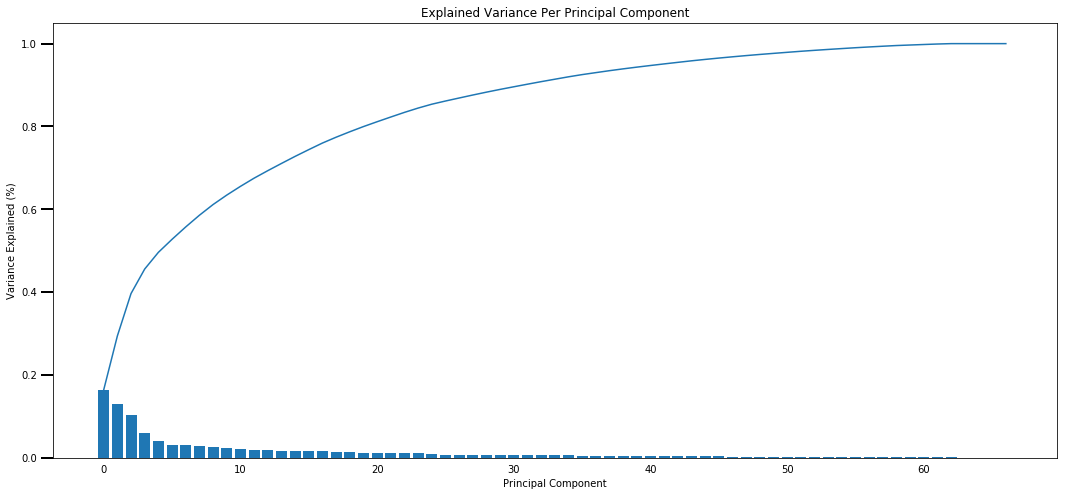

In [173]:
# From course lab 
def scree_plot(pca, components_no=None, show_labels=False):

    vals = pca.explained_variance_ratio_
    if components_no:
        vals = vals[:components_no]
    num_components = len(vals)
    ind = np.arange(num_components)
 
    plt.figure(figsize=(18, 8))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    if show_labels:
        for i in range(num_components):
            ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
scree_plot(pca, show_labels=False)



Text(0.5,1,'Cumulative Explained Variance vs No. of Principal Components')

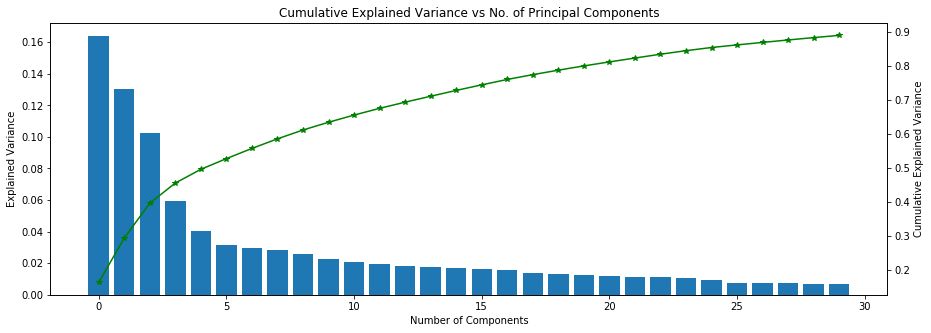

In [174]:
# Re-apply PCA to the data while selecting for number of components to retain.
n_components = 30;
pca = PCA(n_components)
missing_data_rows_below_10_pca = pca.fit_transform(missing_data_rows_below_10)  
# generate sequence for plotting
components = np.arange(n_components)
# Investigate the variance accounted for by each principal component.
fig, ax1 = plt.subplots(figsize=(15,5))
ax1.bar(components,pca.explained_variance_ratio_)
ax1.set_ylabel('Explained Variance')
ax1.set_xlabel('Number of Components')
ax2 = ax1.twinx() 
ax2.plot(np.cumsum(pca.explained_variance_ratio_), color="green",marker='*')
ax2.set_ylabel('Cumulative Explained Variance')
plt.title("Cumulative Explained Variance vs No. of Principal Components")


In [175]:
#check the explained variance ratio
pca.explained_variance_ratio_.sum()

0.88938119821706974

In [176]:
# Number of original features
missing_data_rows_below_10.shape[1]


67

### Discussion 2.2: Perform Dimensionality Reduction

How many principal components / transformed features are you retaining for the next step of the analysis?)

After performing PCA on my dataset, I decided to keep 30 components as the variance per principal component decreased and the first 30 components gave me 88 % explained variance ratio. We now have reduced the dimension from 67 features to 30 PCA components. 


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [177]:
pca.components_

array([[-0.11273491, -0.21800531,  0.14018352, ..., -0.10974472,
         0.20818251, -0.12399637],
       [ 0.24926277,  0.05421343, -0.22442281, ..., -0.01074621,
         0.06380042,  0.00668383],
       [ 0.11430551,  0.15215163, -0.12968774, ...,  0.03615993,
         0.03935356, -0.00979095],
       ..., 
       [-0.03450376,  0.02012152, -0.02363271, ...,  0.02187322,
         0.2016801 ,  0.03022958],
       [-0.05934911,  0.17032338,  0.01122736, ..., -0.01178839,
        -0.03235656, -0.07622616],
       [ 0.06952173, -0.08095158,  0.02054556, ..., -0.0579446 ,
        -0.08057105, -0.08442865]])

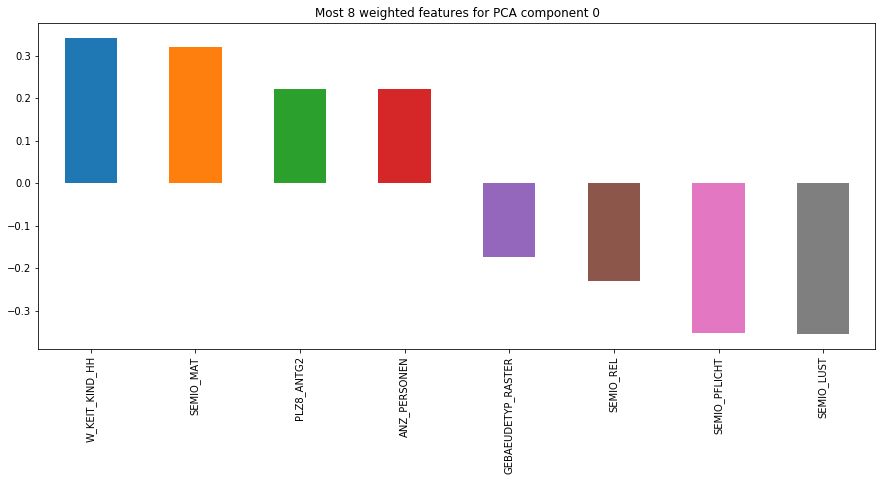

W_KEIT_KIND_HH        0.3413
SEMIO_MAT             0.3209
PLZ8_ANTG2            0.2205
ANZ_PERSONEN          0.2203
GEBAEUDETYP_RASTER   -0.1742
SEMIO_REL            -0.2300
SEMIO_PFLICHT        -0.3512
SEMIO_LUST           -0.3551
Name: 29, dtype: float64

In [178]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

#Visualizing the weights

def plot_pca(data, pca, n_component, features_no, show_plot=True):
    
    # Build a dataframe with features_no features capturing most variability
    # for a given component number (component_no)
    pricomp = pd.DataFrame(np.round(pca.components_, 4), columns=data.keys()).iloc[n_component - 1]
    pricomp.sort_values(ascending=False, inplace=True)
    pricomp = pd.concat([pricomp.head(features_no), pricomp.tail(features_no)])
    
 
    pricomp.plot(kind='bar',
                  title='Most {} weighted features for PCA component {}'.format(features_no*2, n_component),
                  figsize=(15, 6))
    plt.show()
    
    return pricomp
plot_pca(missing_data_rows_below_10, pca, 0, 4)

W_KEIT_KIND_HH: Likelihood of children in household

SEMIO_MAT: Materialistic           

ANZ_PERSONEN: Number of adults in household         

PLZ8_ANTG2: Number of 3-5 family houses in the PLZ8 region   



GEBAEUDETYP_RASTER: Ratio of residential to commercial activity

SEMIO_REL: Religious         

SEMIO_PFLICHT: Dutiful      

SEMIO_LUST: Sensual-minded             



In [179]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

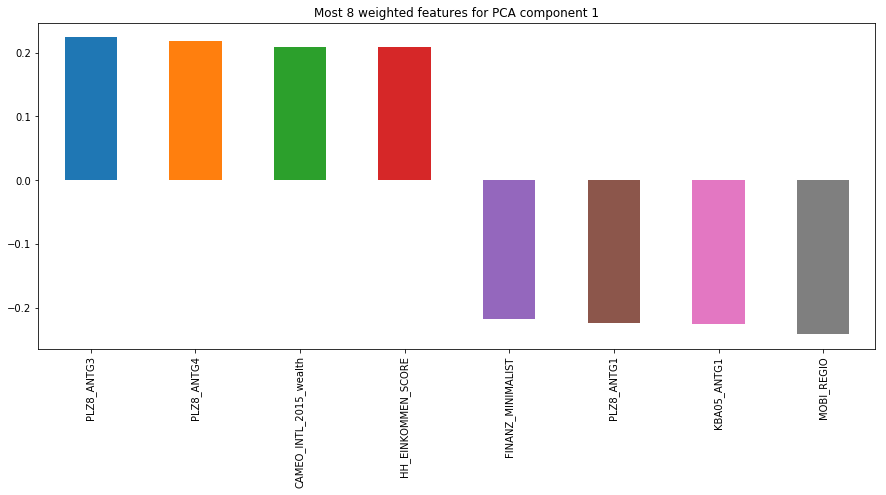

PLZ8_ANTG3                0.2238
PLZ8_ANTG4                0.2175
CAMEO_INTL_2015_wealth    0.2082
HH_EINKOMMEN_SCORE        0.2082
FINANZ_MINIMALIST        -0.2180
PLZ8_ANTG1               -0.2248
KBA05_ANTG1              -0.2259
MOBI_REGIO               -0.2412
Name: 0, dtype: float64

In [180]:
plot_pca(missing_data_rows_below_10, pca, 1, 4)

PLZ8_ANTG3: Number of 6–10 family houses in the PLZ8 region 

PLZ8_ANTG4 : Number of 10+ family houses in the PLZ8 region 

CAMEO_INTL_2015_wealth: Household wealth 

HH_EINKOMMEN_SCORE: Estimated household net income 

FINANZ_MINIMALIST : Financial typology — MINIMALIST: low financial interest

PLZ8_ANTG1: Number of 1–2 family houses in the PLZ8 region 

KBA05_ANTG1 : Number of 1–2 family houses in the microcell 

MOBI_REGIO : Movement patterns




In [181]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

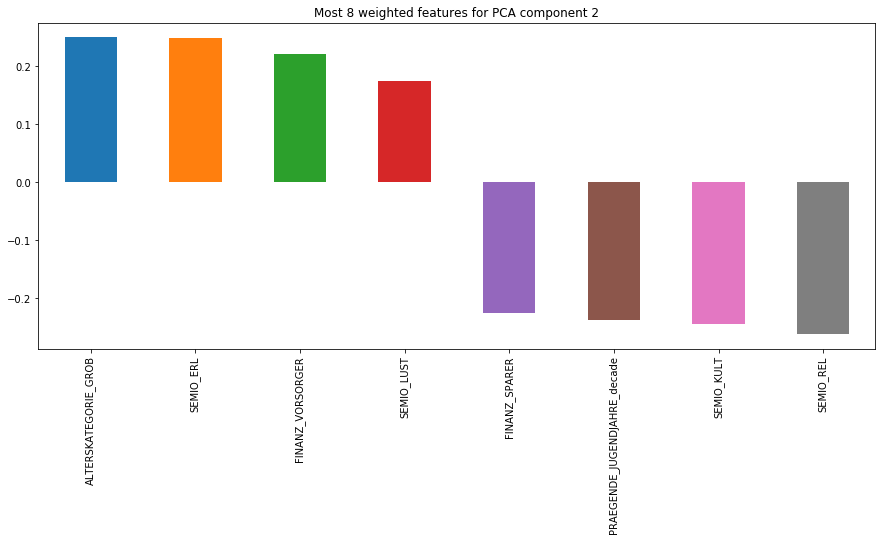

ALTERSKATEGORIE_GROB            0.2493
SEMIO_ERL                       0.2486
FINANZ_VORSORGER                0.2202
SEMIO_LUST                      0.1748
FINANZ_SPARER                  -0.2244
PRAEGENDE_JUGENDJAHRE_decade   -0.2370
SEMIO_KULT                     -0.2447
SEMIO_REL                      -0.2613
Name: 1, dtype: float64

In [182]:
plot_pca(missing_data_rows_below_10, pca, 2, 4)

ALTERSKATEGORIE_GROB: Estimated age based on given name analysis

SEMIO_ERL: Event-oriented personality type

FINANZ_VORSORGER: Financial typology / prevention level 

SEMIO_LUST: Sensual-minded 



FINANZ_SPARER: Financial typology / hoarding level

PRAEGENDE_JUGENDJAHRE_decade: generation to which a person belongs

SEMIO_KULT: Cultural-minded 

SEMIO_REL: Religious





### Discussion 2.3: Interpret Principal Components

Can we interpret positive and negative values from them in a meaningful way?


The principal component number 0 is about size of the household (children and adults), personality (religious, dutiful, sensual-minded). The positive values tells us about household size and being materialistic while the negative values tells about people that are driven by passion, their duty and religion. 


The principal component number 1 is about size of the family, household wealth, income and movement patterns. The positive values tells us that the a larger family has a better household wealth. And a smaller family are minimalist when it comes to economy and moves around. 


The principal component number 2 is about what age, habits and financial aspects (saver and dont take risks (allways prepared). This group values culture, religion and money which indicates conservative personality and indicates an age. 


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [183]:
# Create a toy dataset to reduce computation time
# Reduce the size to 25%
#pca_sample = missing_data_rows_below_10_pca[np.random.choice(missing_data_rows_below_10_pca.shape[0], int(missing_data_rows_below_10_pca.shape[0]*0.25), replace=False)]
#pca_sample 

array([[ 0.95583212,  4.05542237, -0.88661828, ...,  0.86283083,
        -0.78227589, -0.1684405 ],
       [ 6.13101686, -2.03163033, -3.2056622 , ...,  1.18940052,
        -0.32810572, -0.41565697],
       [ 3.39750445,  2.07036727,  3.32075523, ..., -0.84279467,
         1.19625012, -0.57567011],
       ..., 
       [-2.96329275, -6.57759999,  1.62742749, ...,  0.0790108 ,
         0.17261989, -1.05087201],
       [-0.39626772, -4.28226064,  2.47755398, ...,  1.21555852,
         0.38323634, -1.01818811],
       [ 1.91294417,  3.45790197, -0.74422737, ...,  0.20311733,
         0.62886995, -1.05269276]])

Text(0.5,1,'SSE vs. K')

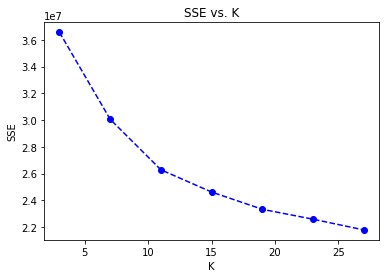

In [199]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and...
    # compute the average within-cluster distances.
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

from sklearn.cluster import KMeans

def kmeans_clustering(data, center):
    kmeans = KMeans(n_clusters=center)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

scores = []
k_list = list(range(3,30,4))

for k in k_list:
    scores.append(kmeans_clustering(missing_data_rows_below_10_pca, k))
    
plt.plot(k_list, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K')
    

In [200]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=11)
model = kmeans.fit(missing_data_rows_below_10_pca)
kmeans_predgeneral = model.predict(missing_data_rows_below_10_pca)

### Discussion 3.1: Apply Clustering to General Population
Into how many clusters have you decided to segment the population?

I have performed Kmeans clustering on the PCA-transformed data and I have decided to segment the population in 11 clusters, where I believe the elbow shape appears in the plot above and where the SSE start to decrease faster. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [201]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [202]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_df_clean=clean_data(customers)
customers_df_clean.shape

(136159, 67)

In [232]:
# Apply PCA to the data
customers_pca = pca.transform(customers_df_clean)

In [233]:
# Re-fit the k-means model 
kmeans = KMeans(k, random_state=1234, max_iter=30, n_jobs=-1).fit(customers_pca)
customer_clusters = kmeans.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

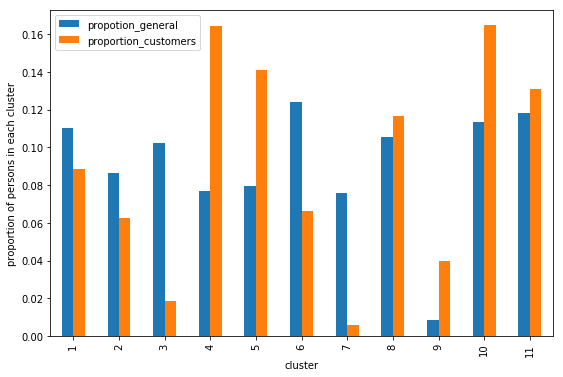

In [234]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
general_pop = []
customers_pop = []
x = [i+1 for i in range(11)]
for i in range(11):
    general_pop.append((kmeans_predgeneral == i).sum()/len(kmeans_predgeneral))
    customers_pop.append((kmeans_pred_customers == i).sum()/len(kmeans_pred_customers))


df_general = pd.DataFrame({'cluster' : x, 'propotion_general' : general_pop, 'proportion_customers':customers_pop})

df_general.plot(x='cluster', y = ['propotion_general', 'proportion_customers'], kind='bar', figsize=(9,6))
plt.ylabel('proportion of persons in each cluster')
plt.show()


In [247]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
data = scaler.inverse_transform(pca.inverse_transform(customers_pca[np.where(kmeans_pred_customers==9)])).round()
df = pd.DataFrame(data=data,
          index=np.array(range(0, data.shape[0])),
          columns=customers_df_clean.columns)

In [236]:
# Top 3 principal components of cluster 9
cluster_9 = kmeans.cluster_centers_[9]
cluster_9 = pd.Series(cluster_9)
cluster_9.sort_values(ascending=False, inplace=True)
print(cluster_9.head(3))

# Transform cluster 9 to original feature values
cluster_9 = scaler.inverse_transform(pca.inverse_transform(cluster_9))
cluster_9 = pd.Series(cluster_9).round()
cluster_9.index = customers_df_clean.columns

16    1014.096269
15     894.553661
24     569.511871
dtype: float64


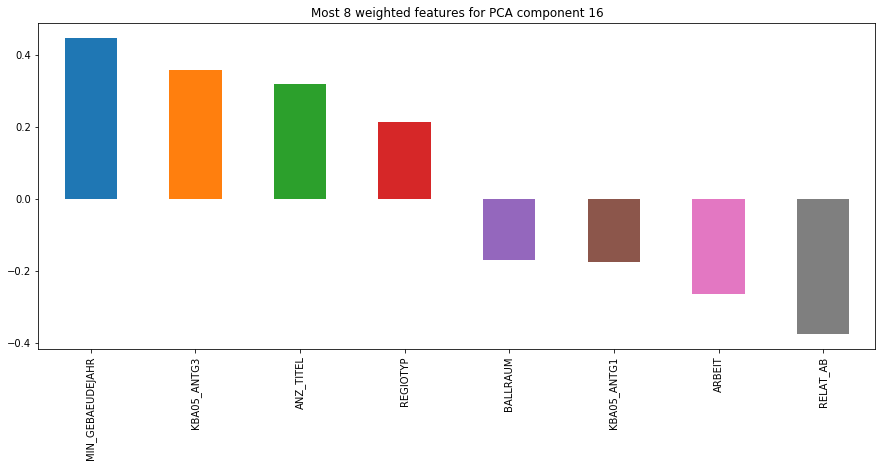

MIN_GEBAEUDEJAHR    0.4480
KBA05_ANTG3         0.3601
ANZ_TITEL           0.3214
REGIOTYP            0.2147
BALLRAUM           -0.1678
KBA05_ANTG1        -0.1751
ARBEIT             -0.2619
RELAT_AB           -0.3756
Name: 15, dtype: float64

In [243]:
# Analyze top 2 principal components of cluster 9
plot_pca(customers_df_clean, pca, 16, 4, False)



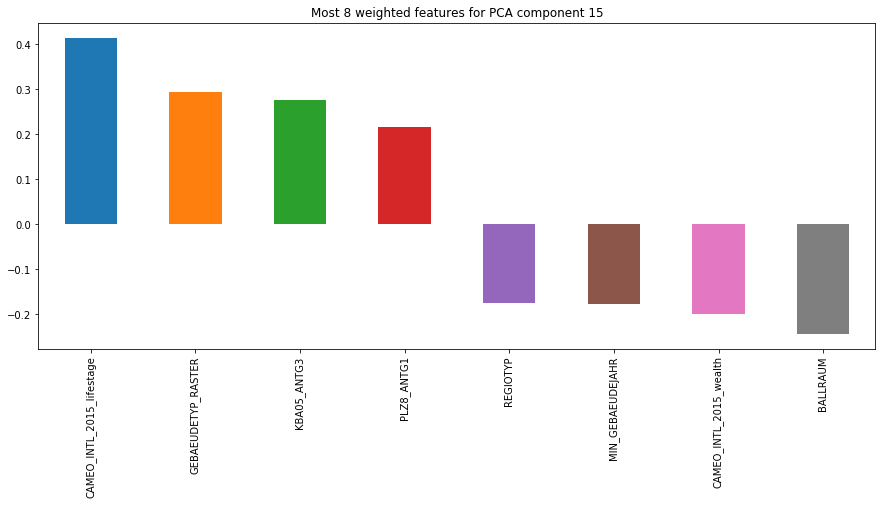

CAMEO_INTL_2015_lifestage    0.4147
GEBAEUDETYP_RASTER           0.2933
KBA05_ANTG3                  0.2767
PLZ8_ANTG1                   0.2154
REGIOTYP                    -0.1760
MIN_GEBAEUDEJAHR            -0.1771
CAMEO_INTL_2015_wealth      -0.2001
BALLRAUM                    -0.2444
Name: 14, dtype: float64

In [244]:
plot_pca(customers_df_clean, pca, 15, 4, False)

MIN_GEBAEUDEJAHR            - First year building was mentioned in the database
KBA05_ANTG3                 - Number of 6-10 family houses in the microcell      
REGIOTYP                    - Neighborhood typology
BALLRAUM                    - Distance to nearest urban center
KONSUMNAEHE                 - Distance from building to point of sale (PoS)
KBA05_ANTG1                 - Number of 1-2 family houses in the microcell
ARBEIT                      - Share of unemployment in community
RELAT_AB                    - Share of unemployment relative to county in which community is contained

In [248]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
data = scaler.inverse_transform(pca.inverse_transform(customers_pca[np.where(kmeans_pred_customers==7)])).round()
df = pd.DataFrame(data=data,
          index=np.array(range(0, data.shape[0])),
          columns=customers_df_clean.columns)


In [223]:
# Top 3 principal components of cluster 7
cluster_7 = kmeans.cluster_centers_[7]
cluster_7 = pd.Series(cluster_7)
cluster_7.sort_values(ascending=False, inplace=True)
print(cluster_7.head(3))

# Transform cluster 7 to original feature values
cluster_7 = scaler.inverse_transform(pca.inverse_transform(cluster_7))
cluster_7 = pd.Series(cluster_7).round()
cluster_7.index = customers_df_clean.columns

16    1013.316805
15     895.288396
24     566.706915
dtype: float64


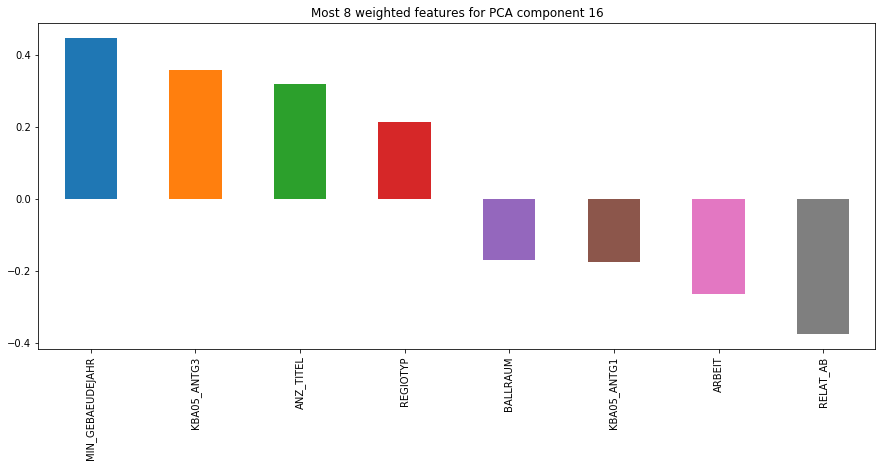

MIN_GEBAEUDEJAHR    0.4480
KBA05_ANTG3         0.3601
ANZ_TITEL           0.3214
REGIOTYP            0.2147
BALLRAUM           -0.1678
KBA05_ANTG1        -0.1751
ARBEIT             -0.2619
RELAT_AB           -0.3756
Name: 15, dtype: float64

In [245]:
# Analyze top 2 principal components of cluster 7
plot_pca(customers_df_clean, pca, 16, 4, False)

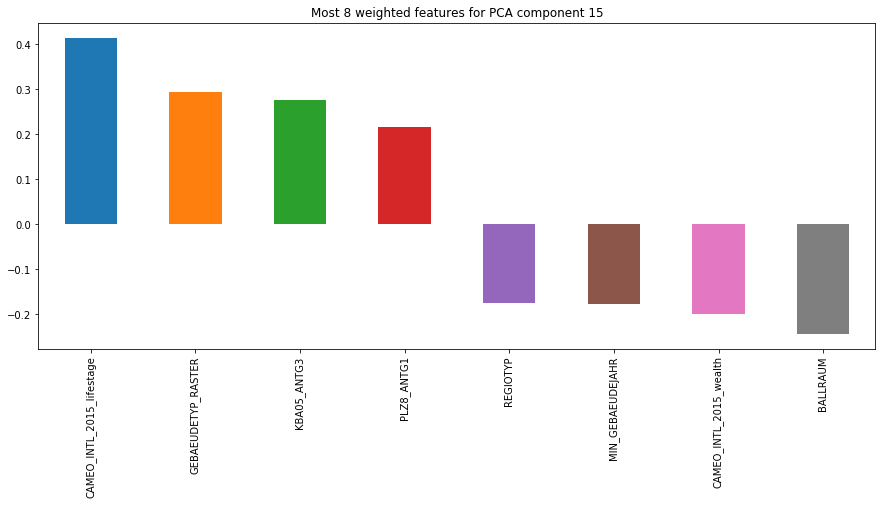

CAMEO_INTL_2015_lifestage    0.4147
GEBAEUDETYP_RASTER           0.2933
KBA05_ANTG3                  0.2767
PLZ8_ANTG1                   0.2154
REGIOTYP                    -0.1760
MIN_GEBAEUDEJAHR            -0.1771
CAMEO_INTL_2015_wealth      -0.2001
BALLRAUM                    -0.2444
Name: 14, dtype: float64

In [246]:
plot_pca(customers_df_clean, pca, 15, 4, False)

In [ ]:
CAMEO_INTL_2015_lifestage    - German CAMEO: Wealth / Life Stage Typology
GEBAEUDETYP_RASTER           - Ratio of residential to commercial activity         
KBA05_ANTG3                  - Number of 6-10 family houses in the microcell            
PLZ8_ANTG1                   - Number of 1-2 family houses in the PLZ8 region
ARBEIT                       - Share of unemployment in community
REGIOTYP                     - Neighborhood typology 
MIN_GEBAEUDEJAHR             - First year building was mentioned in the database
CAMEO_INTL_2015_wealth       - German CAMEO: Wealth / Life Stage Typology
BALLRAUM                     - Distance to nearest urban center

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)
The cluster analysis shows that the mail-order company are popular around people with a larger household, close to sale points, academic background and unemployment which seems to be mostly students or people that has retired. However, the group that the company has missed seems to be people that are wealthy and young.  

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.